# Setup

In [1]:
%cd /Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive
PROJECT_PATH = '/Users/edoardorossi/Documents/GitHub/Tesi'
CTA30_PATH = '/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive'

import warnings
import pickle
import sys
import os
sys.path.insert(0, os.path.abspath('functions'))
sys.path.insert(0, os.path.abspath(''))
warnings.filterwarnings('ignore')
from pkl import store_data, load_data
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from scipy.optimize import differential_evolution
import random
from collections import defaultdict
import time
import itertools
import joblib
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.layers.experimental import preprocessing
from tensorflow.keras.layers import Dense, Dropout, Activation, Flatten

print("Libraries imported")

/Users/edoardorossi/Documents/Universita/Tesi/Tesi_GDrive


2023-07-10 12:41:52.464141: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Libraries imported


# Import DF

In [2]:
cta30_def_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_def.csv')  
df_def = pd.read_csv(cta30_def_path)


cta30_18_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2018.csv')
cta30_19_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2019.csv')
cta30_20_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2020.csv')
cta30_21_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2021.csv')
cta30_22_path = os.path.join(CTA30_PATH, 'CTA30/DF_clean/clean_CTA_30_2022.csv')

df18= pd.read_csv(cta30_18_path)
df19= pd.read_csv(cta30_19_path)
df20= pd.read_csv(cta30_20_path)
df21= pd.read_csv(cta30_21_path)
df22= pd.read_csv(cta30_22_path)

df_complete = pd.concat([df18, df19, df20, df21, df22], ignore_index=True)

#drop le colonne 'F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00' 
df = df_complete.drop(['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)
# create df_a with only dropped columns
df_a = df_complete[['F_M_FDBK_00', 'VLV_RAF_REG_00', 'VLV_SUR_REG_00']]


df_a['VLV_RAF_REG_00'] = df_a['VLV_RAF_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)
df_a['VLV_SUR_REG_00'] = df_a['VLV_SUR_REG_00'].apply(lambda x: 1 if x>=0.5 else 0)

df_a['VLV'] = 0 # colonna inizializzata a 0
for i in range(len(df)):
    if df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] == 0:
        df_a.loc[i, 'VLV'] = 0
    elif df_a['VLV_RAF_REG_00'][i] == 0 and df_a['VLV_SUR_REG_00'][i] != 0:
        df_a.loc[i, 'VLV'] = -1
    elif df_a['VLV_RAF_REG_00'][i] != 0 and df_a['VLV_SUR_REG_00'][i] == 0:
        df_a.loc[i, 'VLV'] = 1

df_a = df_a.drop(['VLV_RAF_REG_00', 'VLV_SUR_REG_00'], axis=1)

df_rew = df_complete[['T_AMB_00', 'T_AMB_01', 'T_AMB_02', 'T_AMB_03', 'PW_ATT_M_00', 'T_M_SP_00']]

#df_rew.to_csv(os.path.join(PROJECT_PATH, 'df_rew.csv'), index=False)     

#print shapes of df and df_a and df_rew
print('df shape: ', df.shape)
print('df_a shape: ', df_a.shape)
print('df_rew shape: ', df_rew.shape)

df.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'), index=False)
df_a.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'), index=False)
df_rew.to_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv'), index=False)




df shape:  (2176378, 73)
df_a shape:  (2176378, 2)
df_rew shape:  (2176378, 6)


In [6]:
df = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df.csv'))
df_a = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_a.csv'))
df_rew = pd.read_csv(os.path.join(PROJECT_PATH, 'DQN_data/df_rew.csv'))

## Normalization

In [3]:
path_scale_norm ='DQN_data/scaler_norm.pkl'
scaler_path = os.path.join(PROJECT_PATH, path_scale_norm)
print(scaler_path)
try: 
    scale_norm = load_data(scaler_path)
    df_norm = pd.DataFrame(scale_norm.transform(df), columns=df.columns)
    print("Normalization loaded")
except:
    print("Computing normalization")
    scale_norm = MinMaxScaler()
    df_norm = pd.DataFrame(scale_norm.fit_transform(df), columns=df.columns)
    store_data(scale_norm, scaler_path)

print("The dataset has", df_norm.shape[1], "columns after normalization")

path_pca_norm = 'DQN_data/pca_norm.pkl'
pca_model_path = os.path.join(PROJECT_PATH, path_pca_norm)
print(pca_model_path)
try:
    pca = load_data(pca_model_path)
    pca_norm = pd.DataFrame(pca.transform(df_norm))
    print("PCA loaded")
except:
    print("Computing PCA")
    pca = PCA(n_components=0.9)
    pca_norm = pd.DataFrame(pca.fit_transform(df_norm))
    store_data(pca, pca_model_path)
    print("PCA computed")
print("The dataset has", pca_norm.shape[1], "columns after PCA")

df_a_norm = pd.DataFrame(scale_norm.fit_transform(df_a), columns=df_a.columns)




/Users/edoardorossi/Documents/GitHub/Tesi/DQN_data/scaler_norm.pkl
Computing normalization
The dataset has 73 columns after normalization
/Users/edoardorossi/Documents/GitHub/Tesi/DQN_data/pca_norm.pkl
PCA loaded
The dataset has 7 columns after PCA


## Action - F: KMeans

In [4]:
DQN_path = 'DQN_data'
folder_name = 'action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, DQN_path, folder_name)
os.makedirs(folder_path, exist_ok=True)
print(folder_path)

X = df_a_norm['F_M_FDBK_00'].values.reshape(-1,1)
k_min = 2
k_max = 10
step = 1


n_clusters_range = range(k_min,k_max+1,step)


for n_clusters in n_clusters_range:
    
    time_start = time.time()
    kmeans = KMeans(n_clusters=(n_clusters), init='k-means++', max_iter=300, n_init=10, random_state=0)
    # se il file è presente in PROJECT_PATH/DQN_path/folder_name non lo ricalcolo
    file_path = os.path.join(folder_path, f'kmeans_{n_clusters}.pkl')
    if os.path.isfile(file_path):
        print(f'kmeans_{n_clusters}.pkl already exists')
    else:
        kmeans.fit(X)
        print(file_path)
        with open(file_path, 'wb') as f:
            pickle.dump(kmeans, f)
        time_elapsed = time.time() - time_start
        print("KMeans with", n_clusters, "clusters computed in", time_elapsed, "seconds")

/Users/edoardorossi/Documents/GitHub/Tesi/DQN_data/action_f_fit_norm
kmeans_2.pkl already exists
kmeans_3.pkl already exists
kmeans_4.pkl already exists
kmeans_5.pkl already exists
kmeans_6.pkl already exists
kmeans_7.pkl already exists
kmeans_8.pkl already exists
kmeans_9.pkl already exists
kmeans_10.pkl already exists


lista file: 
 ['kmeans_2.pkl', 'kmeans_3.pkl', 'kmeans_4.pkl', 'kmeans_5.pkl', 'kmeans_6.pkl', 'kmeans_7.pkl', 'kmeans_8.pkl', 'kmeans_9.pkl', 'kmeans_10.pkl']


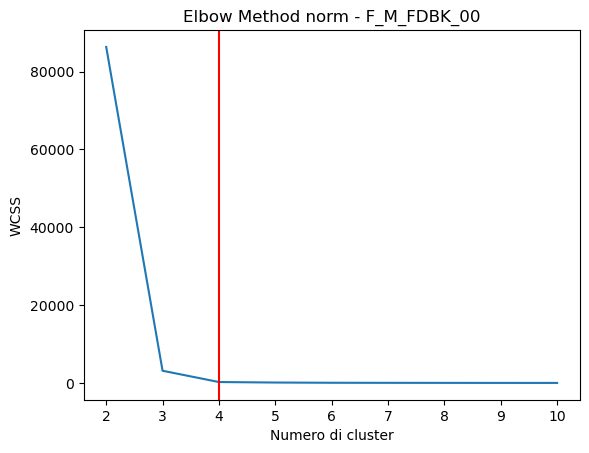

[[9.59514073e-06]
 [4.96453165e-01]
 [9.96612063e-01]
 [3.39540659e-01]]
[2 2 2 ... 0 0 0]
241.4681971098699
1
4
300


In [5]:
# ELBOW graph

from math import log
DQN_path = 'DQN_data'
folder_name = 'action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, DQN_path, folder_name)
os.makedirs(folder_path, exist_ok=True)
file_list = os.listdir(folder_path)

def ordina_file_per_numero(nome_file):
    prefisso = "kmeans_"
    suffisso = ".pkl"
    numero_str = nome_file[len(prefisso):-len(suffisso)]
    numero = int(numero_str)
    return numero

# ordina la lista dei file utilizzando la funzione personalizzata
file_list_ordinata = sorted(file_list, key=ordina_file_per_numero)

x = []
y = []

print('lista file: \n', file_list_ordinata)

for i in range(len(file_list_ordinata)):

    # carica il file pkl
    with open(os.path.join(folder_path, file_list_ordinata[i]), 'rb') as f:
        modello = pickle.load(f)
    
    #esegui la fit su pca_norm 
    #modello.fit(X)

    #assegna alla variabile x il numero di cluster
    x.append(modello.n_clusters)

    #assegna alla variabile y il valore di wcss 
    y.append(modello.inertia_)

do_it = False
if do_it:
    # itera finché y non è ordinata in modo decrescente
    while y != sorted(y, reverse=True):
        remove_index = []
        for i in range(len(y)-1):
            if y[i] < y[i+1]:
                # salva l'indice i in una variabile e aggiungila alla lista degli indici da rimuovere
                remove_index.append(i)
        for i in remove_index:
            del x[i]
            del y[i]

elbow = 4
plt.plot(x,y)
plt.axvline(x=elbow, color='red')
plt.xlabel('Numero di cluster')
plt.ylabel('WCSS')
plt.title('Elbow Method norm - F_M_FDBK_00')
plt.show()

# stampa i centroidi del modello di clustering con 3 cluster
with open(os.path.join(folder_path, file_list_ordinata[elbow-2]), 'rb') as f:
    modello = pickle.load(f)
print(modello.cluster_centers_)
print(modello.labels_)
print(modello.inertia_)
print(modello.n_iter_)
print(modello.n_clusters)
print(modello.max_iter)



## Action - F: Bins

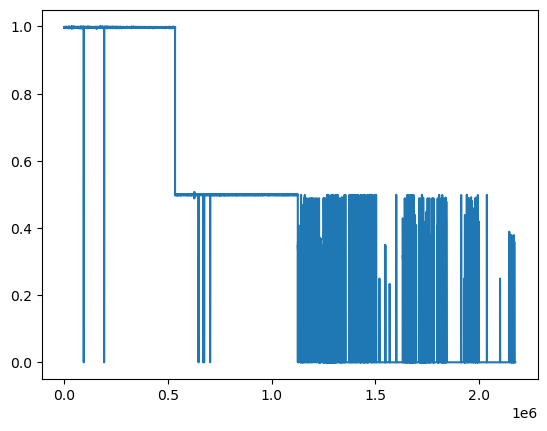

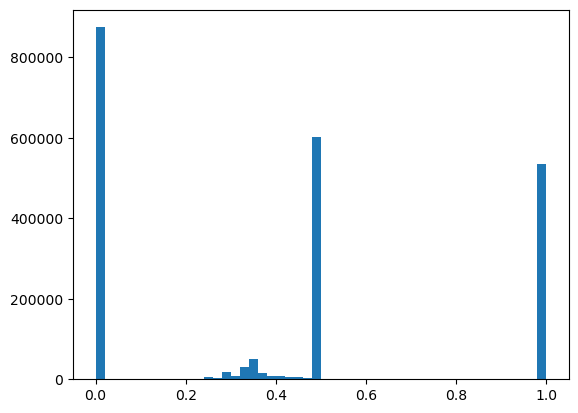

hist:  [874477      1      4      8      6      9      7      5     11      8
      4      5     14      3      5      9      8      5     13   5196
   1435   1823   2435  17170   3563   4201   7383  50065  23965  11178
   5450   7119   4102   2891   3112   7438   2365   2589   1674 602500
      8      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0      0
      0      0      0      0      0      0      0      0      0 534114] 
 len(hist):  80
bin_edges:  [0.     0.0125 0.025  0.0375 0.05   0.0625 0.075  0.0875 0.1    0.1125
 0.125  0.1375 0.15   0.1625 0.175  0.1875 0.2    0.2125 0.225  0.2375
 0.25   0.2625 0.275  0.2875 0.3    0.3125 0.325  0.3375 0.35   0.3625
 0.375  0.3875 0.4    0.4125 0.425  0.4375 0.45   0.4625 0.475  0.4875
 0.5    0.5125 0.525  0.5375 0.55   0.5625 0.575  0.5875 0.6    0.6125
 0.625  0.6375 0.65   0.6625 0.675  0.68

In [34]:
plt.plot(df_a_norm['F_M_FDBK_00'])
plt.show()

#plot bins of F_M_FDBK_00
plt.hist(df_a_norm['F_M_FDBK_00'], bins=50)
plt.show()


# compute bins of F_M_FDBK_00 with histogram with 50 bins
hist, bin_edges = np.histogram(df_a_norm['F_M_FDBK_00'], bins=80)
print('hist: ', hist, '\n len(hist): ', len(hist))
print('bin_edges: ', bin_edges, '\n len(bin_edges): ', len(bin_edges))

#select from bin edges the value of bins that are greater than 1000
dict_hist =[]
bin_edges_selected = []
for i in range(len(hist)):
    if hist[i] >= 1000:
        dict_hist.append(hist[i])
        bin_edges_selected.append(bin_edges[i])

#populate a dictionary with key dict_hist and value bin_edges_selected
dict_hist_bin_edges = {}
for i in range(len(dict_hist)):
    dict_hist_bin_edges[dict_hist[i]] = bin_edges_selected[i]

with open(os.path.join(PROJECT_PATH, 'f_m_bins.pkl'), 'wb') as f:
    pickle.dump(dict_hist_bin_edges, f)



print('bin_edges_selected: ', bin_edges_selected, '\n len(bin_edges_selected): ', len(bin_edges_selected))

#save a dictionary with key = hist and value = index of bin_edges_selected
dict_bin_edges = {}
for i in range(len(bin_edges_selected)):
    dict_bin_edges[bin_edges_selected[i]] = i




# DQN Agent

In [ ]:
def tansig(x):
    return np.tanh(x)

class DQNAgent:
    def __init__(self, state_size, action_size):
        self.state_size = state_size
        self.action_size = action_size
        self.memory = []
        self.gamma = 0.99
        self.epsilon = 1.0
        self.epsilon_min = 0.01
        self.epsilon_decay = 0.995
        self.learning_rate = 0.001  
        self.model = self._build_model()
        

    def _build_model(self):
        
        model = Sequential()
        if self.state_size > 60:
            model.add(Dense(32, input_dim=self.state_size+2, activation=tansig))
            model.add(Dense(16, activation=tansig))
            model.add(Dense(8, activation=tansig))
            model.add(Dense(1, activation=tansig))
            
        else:
            model = Sequential()
            model.add(Dense(9, input_dim=self.state_size+2, activation=tansig))
            model.add(Dense(1, activation=tansig))

        model.compile(loss='mse', optimizer=Adam(lr=self.learning_rate))
        return model        

        
        

    def act(self, state):
        if np.random.rand() <= self.epsilon:
            # Azione casuale
            return random.randrange(self.action_size)
        # Azione migliore
        q_values = self.model.predict(state)
        return np.argmax(q_values[0])
    
    def replay(self, batch_size):
        # Scelgo un batch casuale dalla memoria
        minibatch = random.sample(self.memory, batch_size)
        for state, action, reward, next_state, done in minibatch:
            next_q_values = self.model.predict(next_state)[0]
            best_action = np.argmax(next_q_values)
            target = reward + self.gamma * next_q_values[best_action]
            # Calcolo la Q-target
            target_f = self.model.predict(state)
            target_f[0][action] = target
            # Aggiornamento pesi del modello
            #riga inserita da me per considerare l'azione come parte dello stato
            input_s_a = state + [action]
            self.model.fit(input_s_a, target_f, epochs=1, verbose=0)

        # Aggiorno epsilon
        if self.epsilon > self.epsilon_min:
            self.epsilon *= self.epsilon_decay

    def load(self, name):
        self.model.load_weights(name)

    def save(self, name):
        self.model.save_weights(name)


# DQN - Algorithm

## Rete Neurale

In [56]:
########################### FUNZIONI  #############################

def tansig(x):
    return tf.keras.backend.tanh(x)

def state_reward(state):
    return -state['PW_ATT_M_00']

def state_action(state, action):
    state = state.to_numpy().reshape(1,-1) 
    action = action.to_numpy().reshape(1,-1)
    actions_df = pd.DataFrame(action, columns=['action_1', 'action_2'])
    state_df = pd.DataFrame(state, columns=df_norm.columns)
    s_a = pd.concat([state_df, actions_df], axis=1).to_numpy()
    return s_a

def objective(next_state, x, model):
    q_next = model.predict(state_action(next_state, x), verbose=0)[0][0]    # <class 'numpy.ndarray'> => con [][] diventa un float
    return q_next

def maximization(state, action_set, model):
    len_a1 = 4
    len_a2 = 3
    max_q = float('-inf')
    for i in range(len_a1):
        for j in range(len_a2):
            a0 = action_set[i][0][0]
            a1 = action_set[j][1]
            x0 = pd.Series([a0,a1])
            res = objective(state, x0, model)
            if res > max_q:
                max_q = res
                best_action = x0
    return best_action

def pred_best_q_next(next_state, action_set, model):
        best_action = maximization(next_state, action_set, model)
        s_a = state_action(next_state, best_action)
        q_next_ba = model.predict(s_a, verbose=0)
        return q_next_ba[0][0]  # <class 'numpy.ndarray'> => con [][] diventa un float
        

def save_model(model, folder_name):
    if not os.path.exists(folder_name):
        os.makedirs(folder_name)
    model.save(os.path.join(PROJECT_PATH, 'DQN_data', folder_name, 'model.h5'))

############################# PARAMETERS ############################


my_df = df_norm.copy()  #   MODIFICARE - SOSTITUIRE CON TRAINING SET DA VALIDARE CON TEST SET
my_actions_df = df_a_norm.copy() # MODIFICARE - [...]

alpha = 0.01
gamma = 1

convergence_threshold = 0.0001
convergence = False

# action space composition

f_clusterig_path = 'DQN_data/action_f_fit_norm'
folder_path = os.path.join(PROJECT_PATH, f_clusterig_path)
elbow = 4
with open(os.path.join(folder_path, file_list_ordinata[elbow-2]), 'rb') as f:
    action_f_model = pickle.load(f)
F_M_centroids = action_f_model.cluster_centers_

vlv_values = my_actions_df['VLV'].unique()
action_set = list(itertools.product(F_M_centroids, vlv_values))

iteration = 0
n_save = 5
folder_name = 'NN_model'

########################## RETE NEURALE ##########################

state_size = my_df.shape[1]
input_size = state_size + 2

model = Sequential()
model.add(Dense(32, input_dim=input_size, activation='tanh'))
model.add(Dense(16, activation='tanh'))
model.add(Dense(8, activation='tanh'))
model.add(Dense(1, activation='tanh'))
    
model.compile(loss='mse', optimizer=Adam(lr=0.001))

#load model
model.load_weights(os.path.join(PROJECT_PATH, 'DQN_data', 'model.h5'))
print('Model loaded')


########################### TRAINING ##############################

while not convergence:

    time_start = time.time()

    data_idx = random.randint(0, len(my_df)-1)
    
    state = my_df.iloc[data_idx]   # <class 'pandas.core.series.Series'>
    next_state = my_df.iloc[data_idx+1] # <class 'pandas.core.series.Series'>

    reward = state_reward(state)    #   <class 'numpy.float64'>
    action = my_actions_df.iloc[data_idx]  # <class 'pandas.core.series.Series'>

    s_a = state_action(state, action)   # <class 'numpy.ndarray'>
 
    q_ = model.predict(s_a, verbose=0)[0][0] # <class 'numpy.ndarray'> => con [][] diventa un float
    
    q_next = pred_best_q_next(next_state, action_set, model)    # <class 'numpy.float64'>

    q = q_ + alpha * (reward + gamma * q_next - q_)    # <class 'numpy.float64'>

    q_target = np.array([q])

    model.fit(s_a, q_target, epochs=1, verbose=0)  # richiede ndarray

    if np.abs(q - q_).max() < convergence_threshold:
        convergence = True
    
    iteration += 1
    #save model every 100 iterations
    if iteration % n_save == 0:
        model.save(os.path.join(PROJECT_PATH, 'DQN_data', 'model.h5'))
        print('\n', f'Model saved at iteration {iteration}')
        print(f'Iteration {iteration} completed in {time.time() - time_start} seconds')
        print('delta q: ',np.abs(q - q_).max())

    
    if convergence:
        print(f'Convergence reached at iteration {iteration}')
        save_model(model, folder_name)
        print('Model saved')
        print(f'Iteration {iteration} completed in {time.time() - time_start} seconds')

    



Model saved at iteration 5
Iteration 5 completed in 2.936785936355591 seconds
delta q:  0.0023410370289228544


KeyboardInterrupt: 